In [ ]:
# Mount Google Drive for dataset storage and checkpointing
from google.colab import drive
import os
import zipfile
import random

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings

# To suppress all warnings
warnings.filterwarnings('ignore')

In [ ]:
# Install dependencies
!pip install timm

# Import packages
import os
import time
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from datetime import datetime
import timm  # EfficientNet models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
# Unzip dataset
import os
import zipfile

zip_path = '/content/drive/MyDrive/400mal_600ben/400mal_600ben_224_aug_clahe_combine_normal.zip'
extract_path = '/content/400mal_600ben'

if not os.path.exists(extract_path):
    os.makedirs(extract_path)

print("Unzipping...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Unzip complete!")

# Print directory structure
print("\nFile structure:")
for root, dirs, files in os.walk(extract_path):
    print(f" {root}")
    for f in files[:5]:
        print(f"   - {f}")

Unzipping...
Unzip complete!

File structure:
 /content/400mal_600ben
 /content/400mal_600ben/400mal_600ben_224_aug_clahe_combine_normal
 /content/400mal_600ben/400mal_600ben_224_aug_clahe_combine_normal/400mal_600ben_224_aug_clahe
   - ISIC_3435596.jpg
   - ISIC_5315062_aug.jpg
   - ISIC_3338629.jpg
   - ISIC_4901633_aug.jpg
   - ISIC_8967404.jpg


# **1. DATA DECLARATION**

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
EPOCHS = 15
VERBOSE = True
PRINT_FREQ = 50

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Paths
CSV_PATH = '/content/drive/MyDrive/ISIC_2020_Training_GroundTruth_darkskin.csv'
IMAGE_DIR = '/content/400mal_600ben/400mal_600ben_224_aug_clahe_combine_normal/400mal_600ben_224_aug_clahe'

Using device: cuda


#**2. DATASET & DATALOADER**

In [ ]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import pandas as pd

class JPEGDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx]["image_name"] + ".jpg")
        try:
            image = Image.open(img_name).convert("RGB")
            if self.transform:
                image = self.transform(image)
            label = self.dataframe.iloc[idx]["target"]
            return image, torch.tensor(label, dtype=torch.float32)
        except Exception as e:
            print(f"Error loading {img_name}: {str(e)}")
            dummy_img = torch.zeros(3, IMAGE_SIZE, IMAGE_SIZE)
            return dummy_img, torch.tensor(0.0, dtype=torch.float32)

def prepare_data_with_test(csv_path, image_dir, test_size=0.1, val_size=0.1):
    df = pd.read_csv(csv_path)
    existing = set(os.path.splitext(f)[0] for f in os.listdir(image_dir) if f.endswith(".jpg"))
    df = df[df["image_name"].isin(existing)][["image_name", "target"]].dropna()

    train_val_df, test_df = train_test_split(df, test_size=test_size, random_state=42, stratify=df["target"])
    val_frac = val_size / (1 - test_size)
    train_df, val_df = train_test_split(train_val_df, test_size=val_frac, random_state=42, stratify=train_val_df["target"])

    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_loader = DataLoader(JPEGDataset(train_df, image_dir, transform), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(JPEGDataset(val_df, image_dir, transform), batch_size=BATCH_SIZE)
    test_loader = DataLoader(JPEGDataset(test_df, image_dir, transform), batch_size=BATCH_SIZE)
    full_train_loader = DataLoader(JPEGDataset(train_val_df, image_dir, transform), batch_size=BATCH_SIZE, shuffle=True)

    return train_loader, val_loader, test_loader, full_train_loader, train_val_df, test_df


#**3. MODEL TRAINING LOOP**

In [ ]:
# MODEL SETUP
def setup_model():
    model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=1)
    model = model.to(DEVICE)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, verbose=True)
    return model, criterion, optimizer, scheduler

In [ ]:
# MODEL TRAIN
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, save_path, epochs=EPOCHS):
    best_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)
        avg_train_loss = total_loss / len(train_loader.dataset)

        val_loss, val_metrics = evaluate_model(model, criterion, val_loader)
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | AUC: {val_metrics['auc']:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print("Saved best model.")

# **4. EVALUATION**

In [ ]:
# EVALUATION
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
import numpy as np

def evaluate_model(model, criterion, loader):
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader.dataset), {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, zero_division=0),
        'recall': recall_score(all_labels, all_preds, zero_division=0),
        'auc': roc_auc_score(all_labels, all_probs),
        'fpr': roc_curve(all_labels, all_probs)[0],
        'tpr': roc_curve(all_labels, all_probs)[1]
    }

# **5. GRAD-CAM**

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_last_conv_layer(model):
    try:
        return model.features[-1]
    except AttributeError:
        return model.conv_head

def generate_gradcam(model, image_tensor):
    model.eval()
    gradients = []
    activations = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    target_layer = get_last_conv_layer(model)
    handle_f = target_layer.register_forward_hook(forward_hook)
    handle_b = target_layer.register_backward_hook(backward_hook)

    output = model(image_tensor.unsqueeze(0).to(DEVICE)).squeeze()

    if output.dim() == 0:
        pred_prob = torch.sigmoid(output).item()
        pred_label = int(pred_prob > 0.5)
        target_score = output
    else:
        pred_prob = torch.softmax(output, dim=-1)
        pred_label = torch.argmax(pred_prob).item()
        target_score = output[pred_label]

    model.zero_grad()
    target_score.backward(retain_graph=True)

    grads = gradients[0].detach().cpu().numpy()[0]
    acts = activations[0].detach().cpu().numpy()[0]

    weights = grads.mean(axis=(1, 2))

    cam = np.sum(weights[:, None, None] * acts, axis=0)

    cam = np.maximum(cam, 0)

    cam = cv2.resize(cam, (IMAGE_SIZE, IMAGE_SIZE))

    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-6)
    cam = (cam * 255).astype(np.uint8)

    handle_f.remove()
    handle_b.remove()

    gradients.clear()
    activations.clear()

    return cam, pred_prob, pred_label

def overlay_cam_on_image(img_original_pil, cam):
    img_np = np.asarray(img_original_pil).astype(np.float32)

    original_width, original_height = img_original_pil.size

    heatmap_resized = cv2.resize(cam, (original_width, original_height))

    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    img_np_normalized = img_np / 255.0
    heatmap_colored_normalized = heatmap_colored / 255.0

    overlay = heatmap_colored_normalized * 0.4 + img_np_normalized * 0.6

    overlay = np.clip(overlay, 0, 1) * 255

    overlay = overlay.astype(np.uint8)

    return overlay

def predict_image_with_gradcam(model, image_path):
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img_original_pil = Image.open(image_path).convert("RGB")

    image_tensor = transform(img_original_pil)

    cam, prob, label = generate_gradcam(model, image_tensor)

    overlay_img = overlay_cam_on_image(img_original_pil, cam)

    class_name = 'Malignant' if label else 'Benign'
    print(f"Prediction: {class_name} (Prob: {prob:.4f})")

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.imshow(img_original_pil)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlay_img)
    plt.title(f"Grad-CAM ({class_name})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# **6. MAIN EXECUTION**

In [ ]:
%%time
train_loader, val_loader, test_loader, full_train_loader, train_val_df, test_df = prepare_data_with_test(CSV_PATH, IMAGE_DIR)

dark_skin_normal_combined, criterion, optimizer, scheduler = setup_model()
MODEL_PATH = '/content/drive/MyDrive/efficientnet_model_dark_skin_normal_combined.pth'

train_model(dark_skin_normal_combined, criterion, optimizer, scheduler, train_loader, val_loader, MODEL_PATH)

dark_skin_normal_combined.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
dark_skin_normal_combined.to(DEVICE)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch 1/15 | Train Loss: 1.6813 | Val Loss: 1.7590 | AUC: 0.6879
Saved best model.
Epoch 2/15 | Train Loss: 0.4984 | Val Loss: 1.7314 | AUC: 0.6841
Saved best model.
Epoch 3/15 | Train Loss: 0.2030 | Val Loss: 1.5881 | AUC: 0.7326
Saved best model.
Epoch 4/15 | Train Loss: 0.1137 | Val Loss: 1.5251 | AUC: 0.7400
Saved best model.
Epoch 5/15 | Train Loss: 0.0876 | Val Loss: 1.5635 | AUC: 0.7458
Epoch 6/15 | Train Loss: 0.0546 | Val Loss: 1.6904 | AUC: 0.7430
Epoch 7/15 | Train Loss: 0.0495 | Val Loss: 1.5503 | AUC: 0.7517
Epoch 8/15 | Train Loss: 0.0480 | Val Loss: 1.5581 | AUC: 0.7484
Epoch 9/15 | Train Loss: 0.0594 | Val Loss: 1.5903 | AUC: 0.7432
Epoch 10/15 | Train Loss: 0.0461 | Val Loss: 1.5380 | AUC: 0.7488
Epoch 11/15 | Train Loss: 0.0344 | Val Loss: 1.6378 | AUC: 0.7447
Epoch 12/15 | Train Loss: 0.0413 | Val Loss: 1.5792 | AUC: 0.7416
Epoch 13/15 | Train Loss: 0.0442 | Val Loss: 1.4972 | AUC: 0.7504
Saved best model.
Epoch 14/15 | Train Loss: 0.0252 | Val Loss: 1.5530 | AUC: 0.

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [ ]:
# ===== COMPREHENSIVE MODEL SAVING =====

import torch
import json
from datetime import datetime
import os

# Create a timestamp for unique model naming
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Define save directory
SAVE_DIR = '/content/drive/MyDrive/saved_models'
os.makedirs(SAVE_DIR, exist_ok=True)

# Model file paths
MODEL_STATE_PATH = f'{SAVE_DIR}/efficientnet_dark_skin_model_{timestamp}.pth'
FULL_MODEL_PATH = f'{SAVE_DIR}/efficientnet_dark_skin_full_model_{timestamp}.pth'
MODEL_INFO_PATH = f'{SAVE_DIR}/model_info_{timestamp}.json'

print("=== SAVING TRAINED MODEL ===")

# 1. Save model state dict (recommended for loading)
torch.save(dark_skin_normal_combined.state_dict(), MODEL_STATE_PATH)
print(f"✓ Model state dict saved to: {MODEL_STATE_PATH}")

# 2. Save complete model (includes architecture)
torch.save(dark_skin_normal_combined, FULL_MODEL_PATH)
print(f"✓ Full model saved to: {FULL_MODEL_PATH}")

# 3. Save model configuration and training info
model_info = {
    'model_architecture': 'efficientnet_b0',
    'num_classes': 1,
    'image_size': IMAGE_SIZE,
    'batch_size': BATCH_SIZE,
    'epochs_trained': EPOCHS,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    'optimizer': 'AdamW',
    'scheduler': 'ReduceLROnPlateau',
    'loss_function': 'BCEWithLogitsLoss',
    'dataset_info': {
        'csv_path': CSV_PATH,
        'image_dir': IMAGE_DIR,
        'train_samples': len(train_loader.dataset),
        'val_samples': len(val_loader.dataset),
        'test_samples': len(test_loader.dataset)
    },
    'preprocessing': {
        'resize': f'({IMAGE_SIZE}, {IMAGE_SIZE})',
        'normalization_mean': [0.485, 0.456, 0.406],
        'normalization_std': [0.229, 0.224, 0.225]
    },
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'device_used': str(DEVICE)
}

# Save model info as JSON
with open(MODEL_INFO_PATH, 'w') as f:
    json.dump(model_info, f, indent=4)
print(f"✓ Model information saved to: {MODEL_INFO_PATH}")

# 4. Evaluate and save final performance metrics
print("\n=== FINAL MODEL EVALUATION ===")

# Test on validation set
val_loss, val_metrics = evaluate_model(dark_skin_normal_combined, criterion, val_loader)
print(f"Final Validation Metrics:")
print(f"  Loss: {val_loss:.4f}")
print(f"  Accuracy: {val_metrics['accuracy']:.4f}")
print(f"  Precision: {val_metrics['precision']:.4f}")
print(f"  Recall: {val_metrics['recall']:.4f}")
print(f"  AUC: {val_metrics['auc']:.4f}")

# Test on test set
test_loss, test_metrics = evaluate_model(dark_skin_normal_combined, criterion, test_loader)
print(f"\nFinal Test Metrics:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_metrics['accuracy']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall: {test_metrics['recall']:.4f}")
print(f"  AUC: {test_metrics['auc']:.4f}")

# Add performance metrics to model info
model_info['final_performance'] = {
    'validation': {
        'loss': float(val_loss),
        'accuracy': float(val_metrics['accuracy']),
        'precision': float(val_metrics['precision']),
        'recall': float(val_metrics['recall']),
        'auc': float(val_metrics['auc'])
    },
    'test': {
        'loss': float(test_loss),
        'accuracy': float(test_metrics['accuracy']),
        'precision': float(test_metrics['precision']),
        'recall': float(test_metrics['recall']),
        'auc': float(test_metrics['auc'])
    }
}

# Update the JSON file with performance metrics
with open(MODEL_INFO_PATH, 'w') as f:
    json.dump(model_info, f, indent=4)

# 5. Create a model loading helper function and save it
LOADER_SCRIPT_PATH = f'{SAVE_DIR}/load_model_{timestamp}.py'

loader_script = f'''
# Model Loading Script
# Generated on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

import torch
import timm
import json

def load_trained_model(device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Load the trained EfficientNet model for skin cancer classification

    Returns:
        model: Loaded PyTorch model
        model_info: Dictionary containing model configuration
    """

    # Load model info
    with open('{MODEL_INFO_PATH}', 'r') as f:
        model_info = json.load(f)

    # Create model architecture
    model = timm.create_model('efficientnet_b0', pretrained=False, num_classes=1)

    # Load trained weights
    state_dict = torch.load('{MODEL_STATE_PATH}', map_location=device)
    model.load_state_dict(state_dict)

    # Set to evaluation mode
    model.eval()
    model.to(device)

    print("Model loaded successfully!")
    print(f"Model trained on: {{model_info['training_date']}}")
    print(f"Final test accuracy: {{model_info['final_performance']['test']['accuracy']:.4f}}")
    print(f"Final test AUC: {{model_info['final_performance']['test']['auc']:.4f}}")

    return model, model_info

# Example usage:
# model, info = load_trained_model()
'''

with open(LOADER_SCRIPT_PATH, 'w') as f:
    f.write(loader_script)
print(f"✓ Model loader script saved to: {LOADER_SCRIPT_PATH}")

# 6. Save optimizer and scheduler states (for potential training resumption)
OPTIMIZER_PATH = f'{SAVE_DIR}/optimizer_state_{timestamp}.pth'
SCHEDULER_PATH = f'{SAVE_DIR}/scheduler_state_{timestamp}.pth'

torch.save(optimizer.state_dict(), OPTIMIZER_PATH)
torch.save(scheduler.state_dict(), SCHEDULER_PATH)
print(f"✓ Optimizer state saved to: {OPTIMIZER_PATH}")
print(f"✓ Scheduler state saved to: {SCHEDULER_PATH}")

# 7. Create a comprehensive checkpoint for training resumption
CHECKPOINT_PATH = f'{SAVE_DIR}/full_checkpoint_{timestamp}.pth'

checkpoint = {
    'epoch': EPOCHS,
    'model_state_dict': dark_skin_normal_combined.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'val_loss': val_loss,
    'test_loss': test_loss,
    'model_info': model_info
}

torch.save(checkpoint, CHECKPOINT_PATH)
print(f"✓ Full training checkpoint saved to: {CHECKPOINT_PATH}")

print("\n=== MODEL SAVING COMPLETE ===")
print(f"All files saved with timestamp: {timestamp}")
print("\nSaved files:")
print(f"  1. Model weights: {MODEL_STATE_PATH}")
print(f"  2. Full model: {FULL_MODEL_PATH}")
print(f"  3. Model info: {MODEL_INFO_PATH}")
print(f"  4. Loader script: {LOADER_SCRIPT_PATH}")
print(f"  5. Optimizer state: {OPTIMIZER_PATH}")
print(f"  6. Scheduler state: {SCHEDULER_PATH}")
print(f"  7. Full checkpoint: {CHECKPOINT_PATH}")

# Quick verification - test loading the saved model
print("\n=== VERIFICATION: Testing model loading ===")
try:
    # Test loading the state dict
    test_model = timm.create_model('efficientnet_b0', pretrained=False, num_classes=1)
    test_model.load_state_dict(torch.load(MODEL_STATE_PATH, map_location='cpu'))
    print("✓ Model state dict loaded successfully")

    # Test loading full model
    full_model = torch.load(FULL_MODEL_PATH, map_location='cpu')
    print("✓ Full model loaded successfully")

    print("✓ All model files verified and working!")

except Exception as e:
    print(f"❌ Error during verification: {e}")

print("\n" + "="*50)
print("MODEL SAVING AND VERIFICATION COMPLETE!")
print("="*50)

=== SAVING TRAINED MODEL ===
✓ Model state dict saved to: /content/drive/MyDrive/saved_models/efficientnet_dark_skin_model_20250628_063338.pth
✓ Full model saved to: /content/drive/MyDrive/saved_models/efficientnet_dark_skin_full_model_20250628_063338.pth
✓ Model information saved to: /content/drive/MyDrive/saved_models/model_info_20250628_063338.json

=== FINAL MODEL EVALUATION ===
Final Validation Metrics:
  Loss: 1.4868
  Accuracy: 0.6900
  Precision: 0.6154
  Recall: 0.6000
  AUC: 0.7532

Final Test Metrics:
  Loss: 1.0614
  Accuracy: 0.7600
  Precision: 0.6905
  Recall: 0.7250
  AUC: 0.8369
✓ Model loader script saved to: /content/drive/MyDrive/saved_models/load_model_20250628_063338.py
✓ Optimizer state saved to: /content/drive/MyDrive/saved_models/optimizer_state_20250628_063338.pth
✓ Scheduler state saved to: /content/drive/MyDrive/saved_models/scheduler_state_20250628_063338.pth
✓ Full training checkpoint saved to: /content/drive/MyDrive/saved_models/full_checkpoint_20250628_0

Prediction: Benign (Prob: 0.0016)


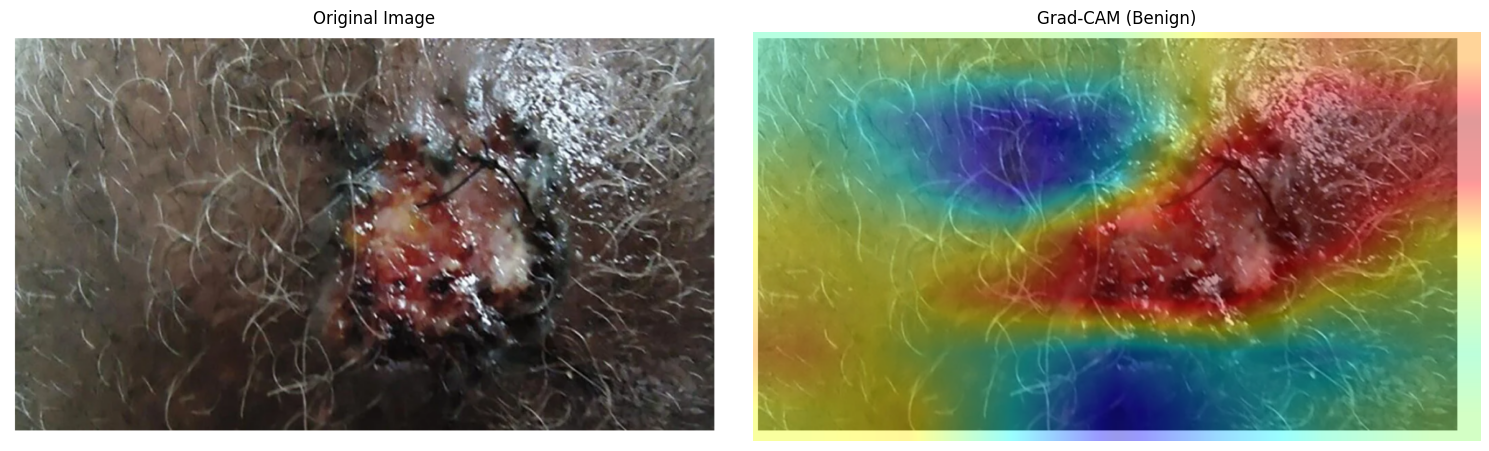

In [ ]:
image_path = '/content/drive/MyDrive/Colab Notebooks/EfficientNet + GradCAM/darkskin_tumor_2.png'
predict_image_with_gradcam(dark_skin_normal_combined, image_path)

Prediction: Malignant (Prob: 0.6701)


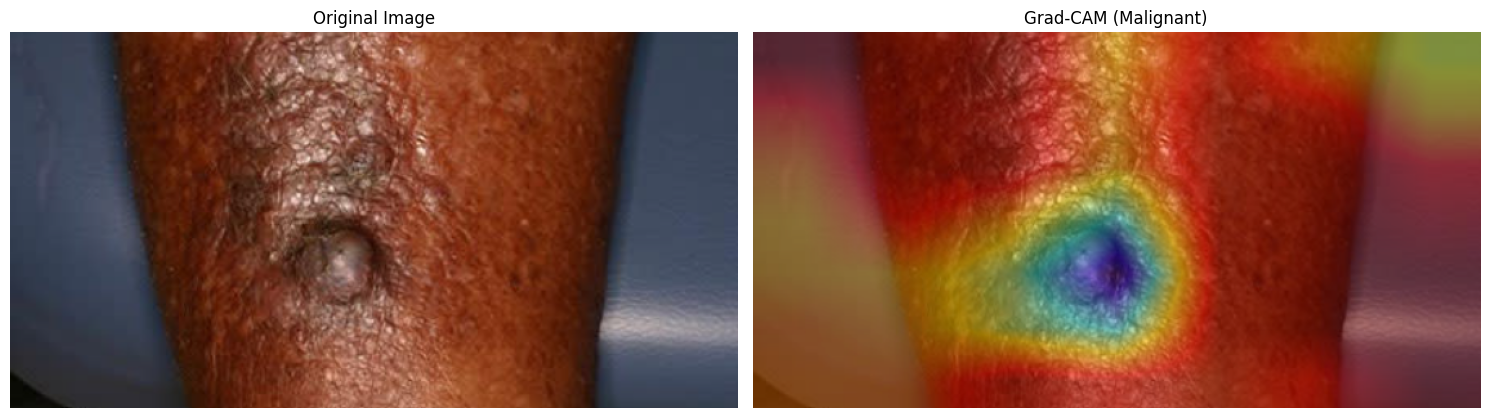

In [ ]:
image_path = '/content/drive/MyDrive/Colab Notebooks/EfficientNet + GradCAM/darkskin_tumor_5.png'
predict_image_with_gradcam(dark_skin_normal_combined, image_path)

In [ ]:
# Cell 1: DDI Dataset Configuration and Paths
import os
import zipfile
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

# DDI Dataset Paths
DDI_ZIP_PATH = '/content/drive/MyDrive/Colab_Notebooks_Testing/ddidiversedermatologyimages/ddidiversedermatologyimages.zip'
DDI_EXTRACT_PATH = '/content/ddi_dataset'
DDI_CSV_PATH = '/content/drive/MyDrive/Colab_Notebooks_Testing/ddidiversedermatologyimages/ddi_metadata.csv'


In [ ]:
# Cell 2: Extract and Explore DDI Dataset

# Create extraction directory
if not os.path.exists(DDI_EXTRACT_PATH):
    os.makedirs(DDI_EXTRACT_PATH)

# Extract DDI dataset
print("Extracting DDI dataset...")
try:
    with zipfile.ZipFile(DDI_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(DDI_EXTRACT_PATH)
    print("DDI dataset extraction complete!")
except Exception as e:
    print(f"Error extracting ZIP file: {e}")

# Print DDI directory structure
print("\nDDI Dataset structure:")
for root, dirs, files in os.walk(DDI_EXTRACT_PATH):
    level = root.replace(DDI_EXTRACT_PATH, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for f in files[:5]:  # Show first 5 files
        print(f"{subindent}{f}")
    if len(files) > 5:
        print(f"{subindent}... and {len(files) - 5} more files")

# Find the actual image directory
def find_image_directory(base_path):
    """Find the directory containing the actual images"""
    for root, dirs, files in os.walk(base_path):
        image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if len(image_files) > 10:  # Consider it an image directory if it has many images
            return root
    return None

ddi_image_dir = find_image_directory(DDI_EXTRACT_PATH)
print(f"\nImage directory found: {ddi_image_dir}")

if ddi_image_dir:
    image_files = [f for f in os.listdir(ddi_image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"Found {len(image_files)} image files")
    print("Sample image files:", image_files[:5])
else:
    print("No image directory found! Please check the extraction.")

Extracting DDI dataset...
DDI dataset extraction complete!

DDI Dataset structure:
ddi_dataset/
  ddidiversedermatologyimages/
    000271.png
    000341.png
    000610.png
    000062.png
    000165.png
    ... and 651 more files

Image directory found: /content/ddi_dataset/ddidiversedermatologyimages
Found 656 image files
Sample image files: ['000271.png', '000341.png', '000610.png', '000062.png', '000165.png']


In [ ]:
DDI_IMAGE_DIR = ddi_image_dir

In [ ]:
# Cell 2: Load Data and Create Dataset

# Load DDI metadata
ddi_df = pd.read_csv(DDI_CSV_PATH)
print(f"Loaded {len(ddi_df)} samples")
print(f"Target distribution:\n{ddi_df['target'].value_counts()}")

class DDIDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = row['DDI_file']

        # Build image path
        image_path = os.path.join(self.image_dir, img_name)

        try:
            image = Image.open(image_path).convert("RGB")
            if self.transform:
                image = self.transform(image)

            label = float(row['target'])
            return image, torch.tensor(label, dtype=torch.float32), img_name

        except Exception as e:
            print(f"Error loading {img_name}: {e}")
            # Return dummy data
            dummy_img = torch.zeros(3, IMAGE_SIZE, IMAGE_SIZE)
            return dummy_img, torch.tensor(0.0, dtype=torch.float32), img_name

# Create transform and dataset
test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

ddi_dataset = DDIDataset(ddi_df, DDI_IMAGE_DIR, test_transform)
ddi_loader = DataLoader(ddi_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Created dataset with {len(ddi_dataset)} samples")
print(f"Number of batches: {len(ddi_loader)}")

Loaded 656 samples
Target distribution:
target
0    485
1    171
Name: count, dtype: int64
Created dataset with 656 samples
Number of batches: 21


In [ ]:
# Cell 3: Run Inference

def test_model(model, dataloader):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, (images, labels, _) in enumerate(dataloader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images).squeeze()
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            all_probs.extend(probs.tolist() if probs.ndim > 0 else [probs.item()])
            all_preds.extend(preds.tolist() if preds.ndim > 0 else [preds.item()])
            all_labels.extend(labels.cpu().numpy().tolist())

            if batch_idx % 10 == 0:
                print(f"Processed {batch_idx + 1}/{len(dataloader)} batches")

    return all_preds, all_probs, all_labels

# Run inference - replace 'your_model' with your actual model variable name
print("Running inference...")
preds, probs, labels = test_model(dark_skin_normal_combined, ddi_loader)  # Change 'your_model' to your model name

print(f"Inference complete! Processed {len(preds)} samples")

Running inference...
Processed 1/21 batches
Processed 11/21 batches
Processed 21/21 batches
Inference complete! Processed 656 samples


=== DDI Dataset Test Results ===
Total samples: 656
Malignant samples: 171.0
Benign samples: 485.0
Accuracy: 0.5244
Precision: 0.2957
Recall: 0.5965
AUC: 0.5770

Classification Report:
              precision    recall  f1-score   support

      Benign       0.78      0.50      0.61       485
   Malignant       0.30      0.60      0.40       171

    accuracy                           0.52       656
   macro avg       0.54      0.55      0.50       656
weighted avg       0.65      0.52      0.55       656



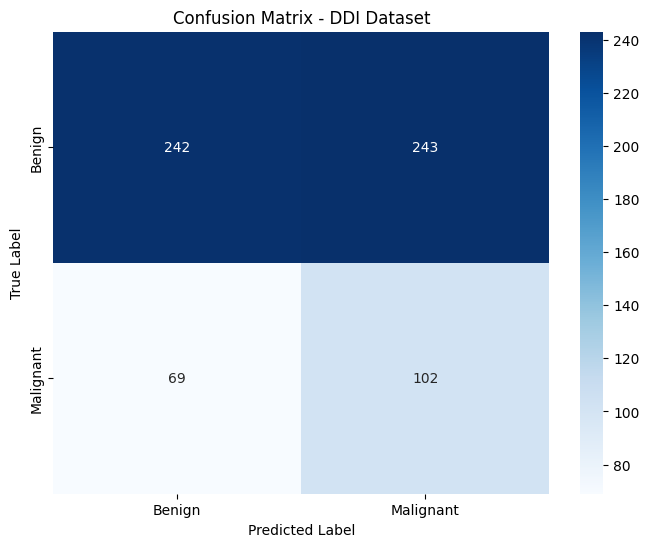


Results saved to: /content/drive/MyDrive/ddi_test_results.csv


In [ ]:
# Cell 4: Calculate Metrics and Results

# Calculate metrics
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds, zero_division=0)
recall = recall_score(labels, preds, zero_division=0)
auc = roc_auc_score(labels, probs)

print("=== DDI Dataset Test Results ===")
print(f"Total samples: {len(labels)}")
print(f"Malignant samples: {sum(labels)}")
print(f"Benign samples: {len(labels) - sum(labels)}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=['Benign', 'Malignant']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix - DDI Dataset')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save results
results_df = pd.DataFrame({
    'DDI_file': ddi_df['DDI_file'].values,
    'true_label': labels,
    'predicted_label': preds,
    'probability': probs,
    'correct': [p == l for p, l in zip(preds, labels)]
})

results_path = '/content/drive/MyDrive/ddi_test_results.csv'
results_df.to_csv(results_path, index=False)
print(f"\nResults saved to: {results_path}")

Setting up Google Drive connection...
Mounted at /content/drive
Google Drive mounted successfully!

Verifying Google Drive mount...
✓ MyDrive accessible
Available directories in MyDrive:
  - Colab Notebooks
  - ISIC_2020_Training_GroundTruth.csv
  - aml-skin-cancer-detection
  - ISIC_2020_Training_JPEG.zip
  - ISIC_2020_Training_JPEG
  - ISIC_2020_Test_Input_resized.zip
  - benign950_malignant50
  - epoch_models
  - Colab_Notebooks_Testing
  - 400mal_600ben
  - 33k Saved Models
  - CLASSIMBALANCE1kV2_efficientnet_model_og.pth
  - efficientnet_skin_best.pth
  - efficientnet_roc_curve.png
  - vit_skin_best.pth
  - malignent_2.jpg
  - malignent_1.jpg
  - benign_3.jpg
  - benign_1.jpg
  - benign_2.jpg
  - malignent_3.jpg
  - malignent_4.jpg
  - efficientnet_model_onlytrain_og.pth
  - model_evaluation_results_original.png
  - efficientnet_model_trainonly_resized.pth
  - model_evaluation_results_resized.png
  - efficientnet_model_Minh.pth
  - pacman_dqn_model_final.pth
  - efficientnet_model

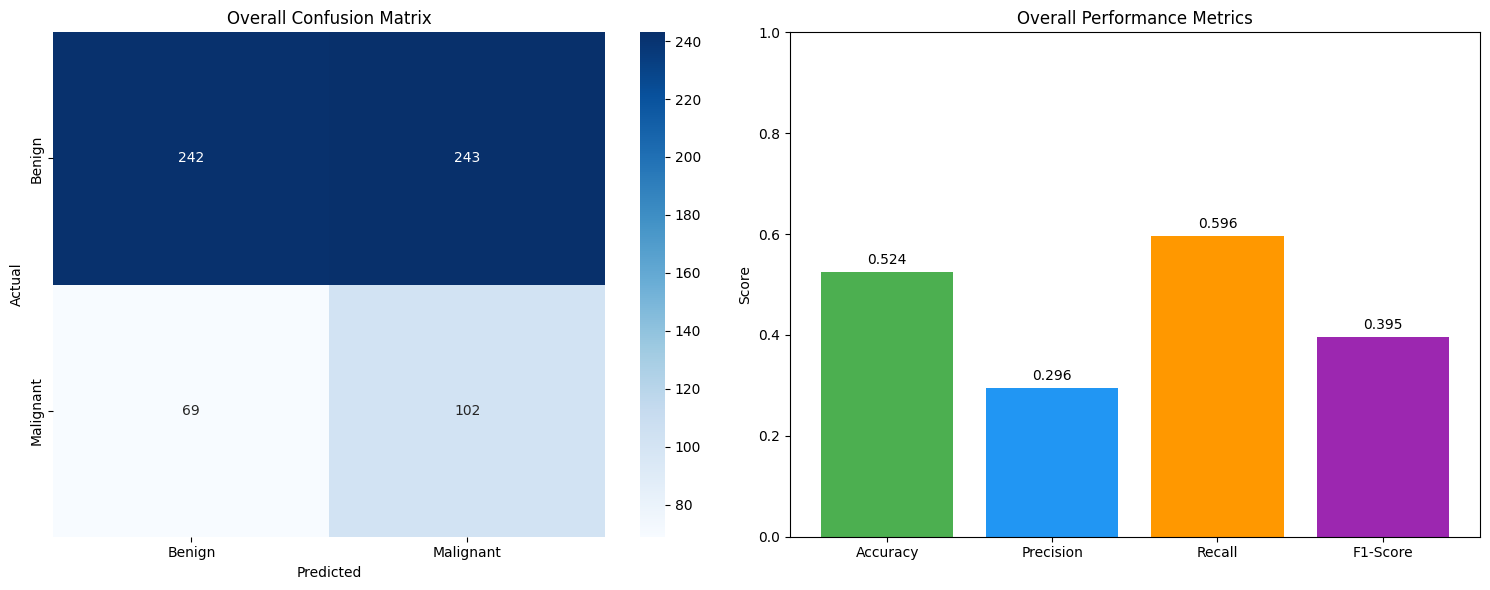


Overall Performance Metrics:
  Accuracy: 0.524
  Precision: 0.296
  Recall: 0.596
  F1-Score: 0.395

Confusion Matrix Details:
  True Negatives (Benign correctly classified): 242
  False Positives (Benign classified as Malignant): 243
  False Negatives (Malignant classified as Benign): 69
  True Positives (Malignant correctly classified): 102

7. PERFORMANCE ANALYSIS BY SKIN TONE
------------------------------

ANALYSIS FOR DARK SKIN TONE
Total samples for dark: 207
Benign cases: 159
Malignant cases: 48


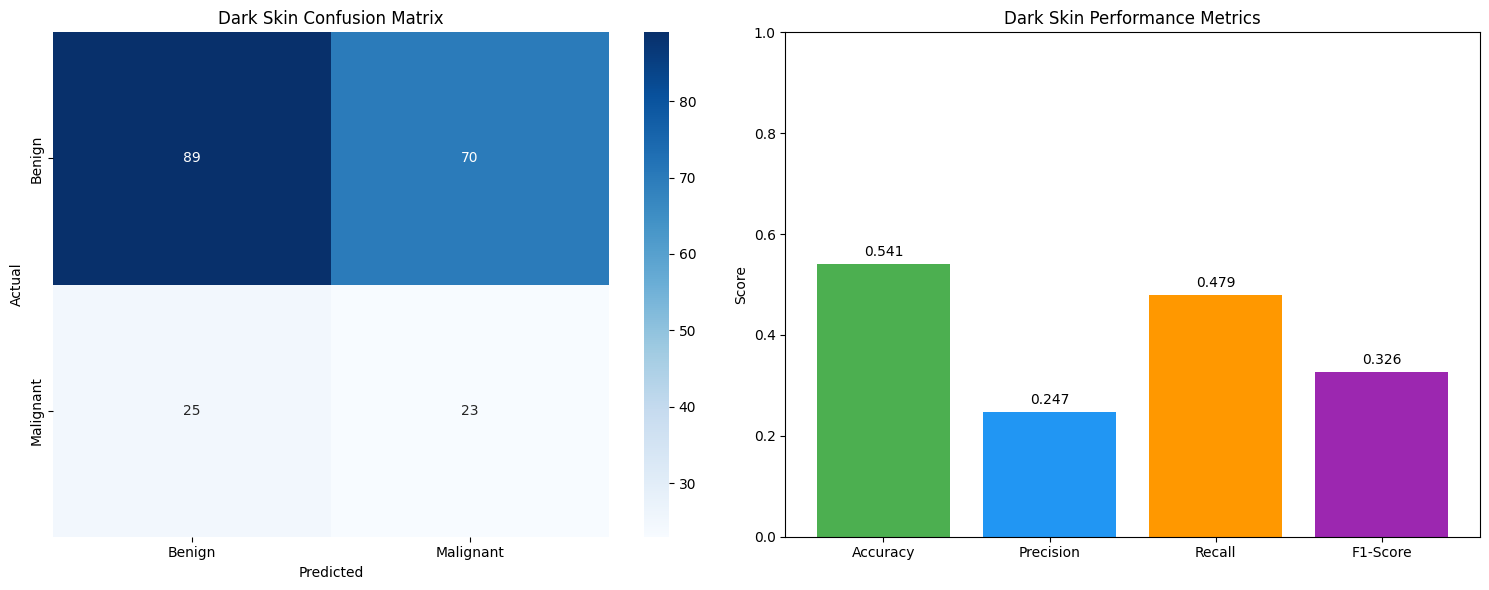


Dark Skin Performance Metrics:
  Accuracy: 0.541
  Precision: 0.247
  Recall: 0.479
  F1-Score: 0.326

Confusion Matrix Details:
  True Negatives (Benign correctly classified): 89
  False Positives (Benign classified as Malignant): 70
  False Negatives (Malignant classified as Benign): 25
  True Positives (Malignant correctly classified): 23

Detailed Analysis for dark skin:
  Benign Classification Accuracy: 0.560
  Malignant Classification Accuracy: 0.479

Error Analysis for dark skin:
  False Positives (Benign → Malignant): 70 (33.8%)
  False Negatives (Malignant → Benign): 25 (12.1%)

ANALYSIS FOR LIGHT SKIN SKIN TONE
Total samples for light skin: 208
Benign cases: 159
Malignant cases: 49


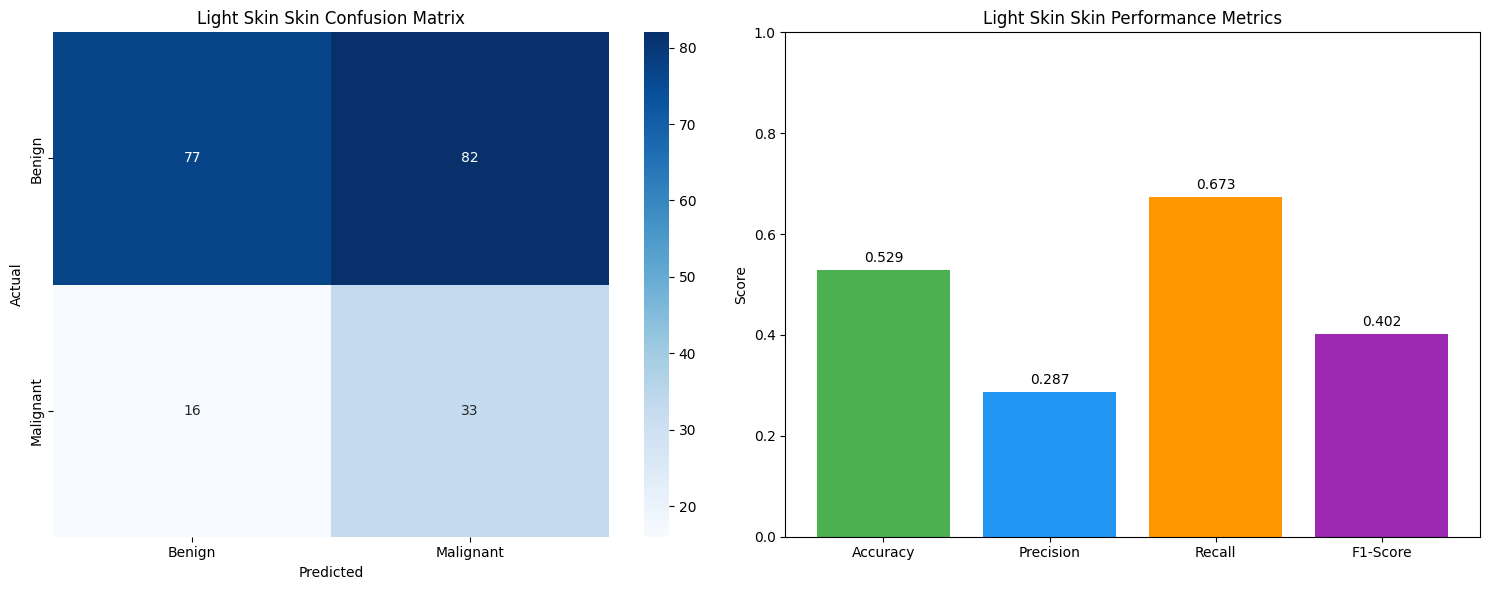


Light Skin Skin Performance Metrics:
  Accuracy: 0.529
  Precision: 0.287
  Recall: 0.673
  F1-Score: 0.402

Confusion Matrix Details:
  True Negatives (Benign correctly classified): 77
  False Positives (Benign classified as Malignant): 82
  False Negatives (Malignant classified as Benign): 16
  True Positives (Malignant correctly classified): 33

Detailed Analysis for light skin skin:
  Benign Classification Accuracy: 0.484
  Malignant Classification Accuracy: 0.673

Error Analysis for light skin skin:
  False Positives (Benign → Malignant): 82 (39.4%)
  False Negatives (Malignant → Benign): 16 (7.7%)

ANALYSIS FOR MEDIUM SKIN TONE
Total samples for medium: 241
Benign cases: 167
Malignant cases: 74


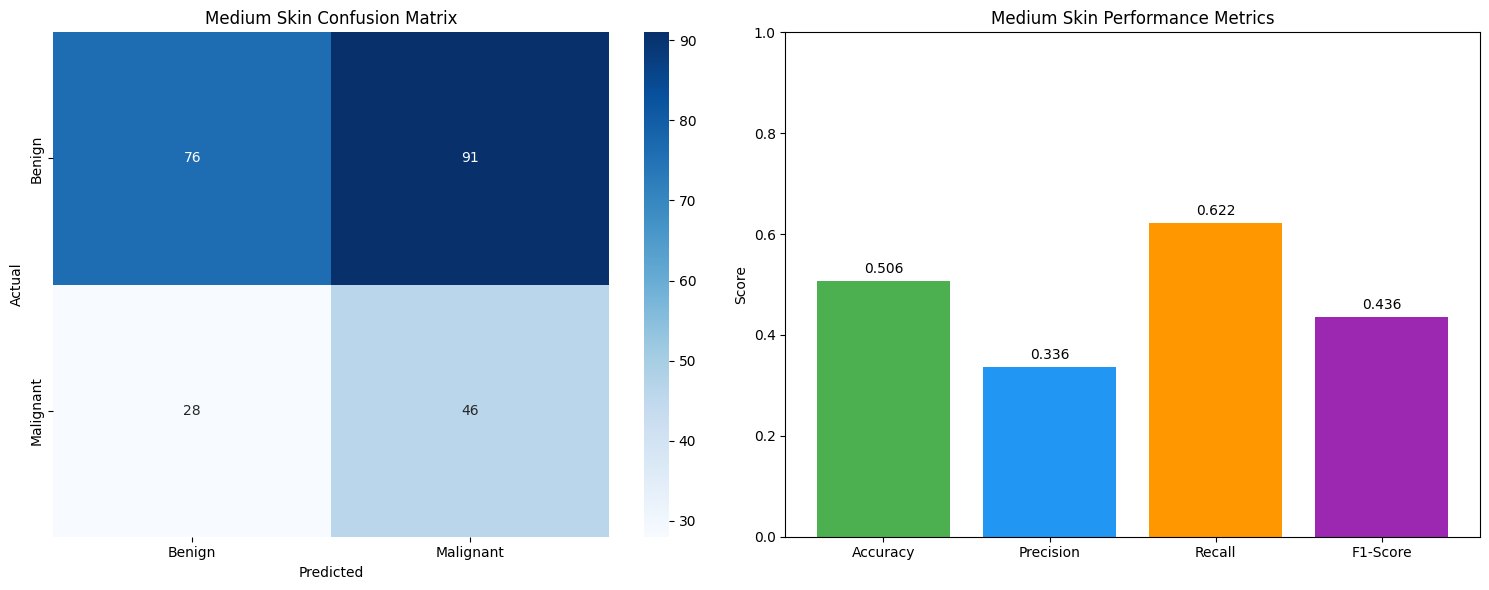


Medium Skin Performance Metrics:
  Accuracy: 0.506
  Precision: 0.336
  Recall: 0.622
  F1-Score: 0.436

Confusion Matrix Details:
  True Negatives (Benign correctly classified): 76
  False Positives (Benign classified as Malignant): 91
  False Negatives (Malignant classified as Benign): 28
  True Positives (Malignant correctly classified): 46

Detailed Analysis for medium skin:
  Benign Classification Accuracy: 0.455
  Malignant Classification Accuracy: 0.622

Error Analysis for medium skin:
  False Positives (Benign → Malignant): 91 (37.8%)
  False Negatives (Malignant → Benign): 28 (11.6%)

8. COMPARATIVE ANALYSIS ACROSS SKIN TONES
------------------------------
Performance comparison across skin tones:
 Skin_Tone  Total_Samples  Benign_Cases  Malignant_Cases  Overall_Accuracy  Precision   Recall  F1_Score  Benign_Accuracy  Malignant_Accuracy  False_Positives  False_Negatives
      dark            207           159               48          0.541063   0.247312 0.479167  0.326241   

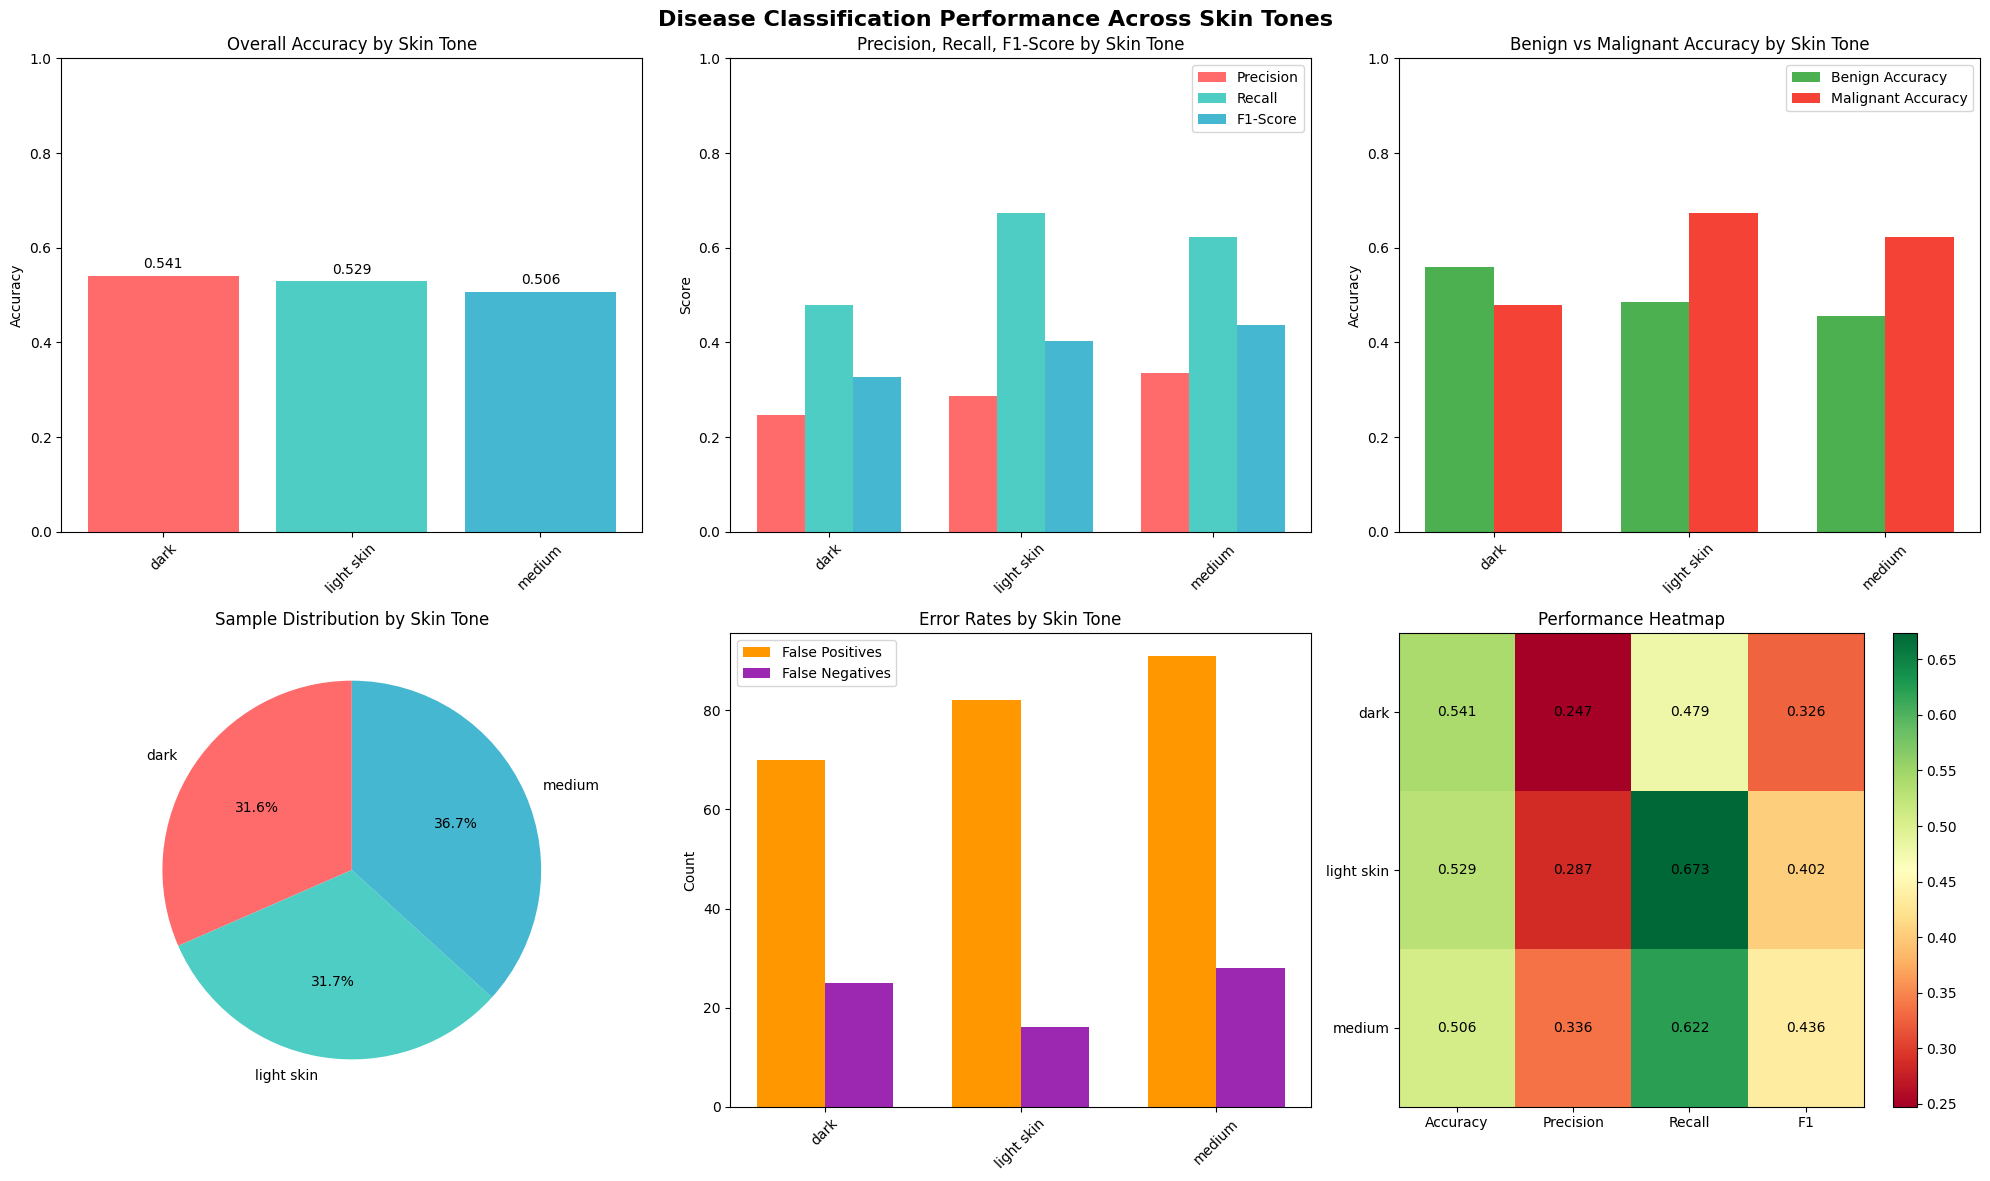


10. STATISTICAL SIGNIFICANCE TESTING
------------------------------
Chi-square test for independence between skin tone and classification accuracy:
(Testing if model performance varies significantly across skin tones)

Contingency Table:
            Correct  Incorrect
dark            112         95
light skin      110         98
medium          122        119

Chi-square statistic: 0.5662
p-value: 0.7535
Degrees of freedom: 2
Result: NOT SIGNIFICANT - No significant variation in model performance across skin tones

11. FAIRNESS ANALYSIS
------------------------------
Fairness metrics across skin tones:
(Lower values indicate more equitable performance)

Overall_Accuracy:
  Range: 0.035 (Max: 0.541, Min: 0.506)
  Standard Deviation: 0.018
  Coefficient of Variation: 0.034

Precision:
  Range: 0.088 (Max: 0.336, Min: 0.247)
  Standard Deviation: 0.044
  Coefficient of Variation: 0.153

Recall:
  Range: 0.194 (Max: 0.673, Min: 0.479)
  Standard Deviation: 0.101
  Coefficient of Variation

In [2]:
# Mount Google Drive and setup environment
print("Setting up Google Drive connection...")
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

# Verify mount and show available directories
print("\nVerifying Google Drive mount...")
if os.path.exists('/content/drive/MyDrive'):
    print("✓ MyDrive accessible")
    print("Available directories in MyDrive:")
    try:
        for item in os.listdir('/content/drive/MyDrive'):
            print(f"  - {item}")
    except Exception as e:
        print(f"  Error listing directories: {e}")
else:
    print("✗ MyDrive not accessible")

# Set working directory
working_dir = '/content/drive/MyDrive/Colab_Notebooks_Testing'
if os.path.exists(working_dir):
    os.chdir(working_dir)
    print(f"\n✓ Changed working directory to: {working_dir}")
else:
    print(f"\n✗ Working directory not found: {working_dir}")
    print("Please verify the path exists in your Google Drive")

print("\n" + "="*60)
print("IMPORTING REQUIRED LIBRARIES")
print("="*60)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from scipy.stats import chi2_contingency

print("All libraries imported successfully!")

print("\n" + "="*60)
print("SKIN TONE PERFORMANCE ANALYSIS FOR DISEASE CLASSIFICATION")
print("="*60)

# Cell 1: Data Overview
print("\n1. DATA OVERVIEW")
print("-" * 30)

# Load the DDI metadata CSV file
ddi_metadata_path = '/content/drive/MyDrive/Colab_Notebooks_Testing/ddidiversedermatologyimages/ddi_metadata.csv'
print(f"Loading DDI metadata from: {ddi_metadata_path}")

try:
    df = pd.read_csv(ddi_metadata_path)
    print(f"✓ Successfully loaded DDI metadata")
    print(f"Total samples: {len(df)}")
    print(f"Columns: {list(df.columns)}")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print(f"✗ DDI metadata file not found at: {ddi_metadata_path}")
    print("Please check the file path and ensure the file exists")
    exit()
except Exception as e:
    print(f"✗ Error loading DDI metadata: {e}")
    exit()

# Cell 2: Load Model Results
print("\n2. LOADING MODEL RESULTS")
print("-" * 30)
print("Loading model results from ddi_test_results.csv...")

# Load the actual model results
model_results_path = '/content/drive/MyDrive/ddi_test_results.csv'
print(f"Model results path: {model_results_path}")

try:
    model_results = pd.read_csv(model_results_path)
    print(f"✓ Model results loaded: {len(model_results)} predictions")
    print(f"Model results columns: {list(model_results.columns)}")

    # Display sample of results to understand the structure
    print("\nModel results sample:")
    print(model_results.head())
except FileNotFoundError:
    print(f"✗ Model results file not found at: {model_results_path}")
    print("Please check the file path and ensure the file exists")
    exit()
except Exception as e:
    print(f"✗ Error loading model results: {e}")
    exit()

# Cell 3: Extract Predictions from Model Results
print("\n3. EXTRACTING PREDICTIONS FROM MODEL RESULTS")
print("-" * 30)

def find_prediction_column(df, description="model"):
    """Find the prediction column in the results dataframe"""
    possible_names = ['prediction', 'pred', 'predicted', 'target_pred', 'y_pred', 'class_pred', 'predictions']

    for col in df.columns:
        if any(name in col.lower() for name in possible_names):
            print(f"Found prediction column for {description}: {col}")
            return col

    # If no prediction column found, show all columns
    print(f"No prediction column found for {description}. Available columns:")
    for i, col in enumerate(df.columns):
        print(f"  {i}: {col}")

    return None

# Find the prediction column
pred_col = find_prediction_column(model_results, "model")

if pred_col:
    model_predictions = model_results[pred_col].values
    print(f"Successfully extracted {len(model_predictions)} predictions from column: {pred_col}")

    # Show prediction distribution
    print(f"\nPrediction distribution:")
    print(pd.Series(model_predictions).value_counts().sort_index())

else:
    print("ERROR: Could not find prediction column!")
    print("Please check the column names in your results file.")
    print("You may need to manually specify the prediction column name.")

    # Show all columns for manual selection
    print("\nAll available columns:")
    for i, col in enumerate(model_results.columns):
        print(f"  {i}: {col}")

    # For demonstration, try to use the first numeric column
    print("\nAttempting to use first numeric column as predictions...")
    for col in model_results.columns:
        if model_results[col].dtype in ['int64', 'float64']:
            print(f"Using {col} as predictions")
            model_predictions = model_results[col].values
            pred_col = col
            break
    else:
        print("ERROR: No suitable prediction column found!")
        exit()

# Cell 4: Validate and Merge Data
print("\n4. VALIDATING AND MERGING DATA")
print("-" * 30)

# Check if we have the same number of samples
print(f"DDI metadata samples: {len(df)}")
print(f"Model predictions: {len(model_predictions)}")

if len(df) != len(model_predictions):
    print("WARNING: Number of samples doesn't match!")
    print("This might cause issues with the analysis.")

    # Try to handle the mismatch
    min_samples = min(len(df), len(model_predictions))
    print(f"Using first {min_samples} samples for analysis.")
    df = df.iloc[:min_samples].copy()
    model_predictions = model_predictions[:min_samples]

# Add predictions to the main dataframe
df['Predicted_Target'] = model_predictions

print(f"Successfully merged data with {len(df)} samples")

# Verify the target and prediction columns exist and are valid
print(f"\nTarget distribution (actual):")
print(df['target'].value_counts().sort_index())
print(f"\nPrediction distribution:")
print(df['Predicted_Target'].value_counts().sort_index())

# Cell 5: SkinTone Distribution Analysis
print("\n5. SKIN TONE DISTRIBUTION")
print("-" * 30)
skin_tone_counts = df['SkinTone'].value_counts()
print("SkinTone distribution:")
for skin_tone, count in skin_tone_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {skin_tone}: {count} samples ({percentage:.1f}%)")

# Cell 6: Overall Performance Analysis
print("\n6. OVERALL PERFORMANCE ANALYSIS")
print("-" * 30)

def analyze_performance(actual, predicted, title="Overall"):
    """
    Analyze performance metrics and create confusion matrix
    """
    # Calculate basic metrics
    accuracy = accuracy_score(actual, predicted)
    precision, recall, f1, _ = precision_recall_fscore_support(actual, predicted, average='binary')

    # Create confusion matrix
    cm = confusion_matrix(actual, predicted)

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'], ax=ax1)
    ax1.set_title(f'{title} Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    # Plot 2: Performance metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [accuracy, precision, recall, f1]
    colors = ['#4CAF50', '#2196F3', '#FF9800', '#9C27B0']

    bars = ax2.bar(metrics, values, color=colors)
    ax2.set_title(f'{title} Performance Metrics')
    ax2.set_ylabel('Score')
    ax2.set_ylim(0, 1)

    # Add value labels on bars
    for bar, value in zip(bars, values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Print detailed metrics
    print(f"\n{title} Performance Metrics:")
    print(f"  Accuracy: {accuracy:.3f}")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"  F1-Score: {f1:.3f}")

    # Print confusion matrix details
    tn, fp, fn, tp = cm.ravel()
    print(f"\nConfusion Matrix Details:")
    print(f"  True Negatives (Benign correctly classified): {tn}")
    print(f"  False Positives (Benign classified as Malignant): {fp}")
    print(f"  False Negatives (Malignant classified as Benign): {fn}")
    print(f"  True Positives (Malignant correctly classified): {tp}")

    return accuracy, precision, recall, f1, cm

# Analyze overall performance
overall_metrics = analyze_performance(df['target'], df['Predicted_Target'], "Overall")

# Cell 7: Performance Analysis by Skin Tone
print("\n7. PERFORMANCE ANALYSIS BY SKIN TONE")
print("-" * 30)

def analyze_skin_tone_performance(skin_tone):
    """
    Analyze performance for a specific skin tone
    """
    print(f"\n{'='*60}")
    print(f"ANALYSIS FOR {skin_tone.upper()} SKIN TONE")
    print(f"{'='*60}")

    # Filter data for this skin tone
    subset = df[df['SkinTone'] == skin_tone].copy()

    print(f"Total samples for {skin_tone}: {len(subset)}")
    print(f"Benign cases: {len(subset[subset['target'] == 0])}")
    print(f"Malignant cases: {len(subset[subset['target'] == 1])}")

    # Check if we have enough samples for meaningful analysis
    if len(subset) < 5:
        print(f"WARNING: Very few samples for {skin_tone} skin tone. Results may not be reliable.")

    # Analyze performance
    accuracy, precision, recall, f1, cm = analyze_performance(
        subset['target'],
        subset['Predicted_Target'],
        f"{skin_tone.title()} Skin"
    )

    # Additional analysis
    print(f"\nDetailed Analysis for {skin_tone} skin:")

    # Calculate metrics for each class
    tn, fp, fn, tp = cm.ravel()

    # Benign performance
    benign_accuracy = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"  Benign Classification Accuracy: {benign_accuracy:.3f}")

    # Malignant performance
    malignant_accuracy = tp / (tp + fn) if (tp + fn) > 0 else 0
    print(f"  Malignant Classification Accuracy: {malignant_accuracy:.3f}")

    # Error analysis
    print(f"\nError Analysis for {skin_tone} skin:")
    print(f"  False Positives (Benign → Malignant): {fp} ({fp/len(subset)*100:.1f}%)")
    print(f"  False Negatives (Malignant → Benign): {fn} ({fn/len(subset)*100:.1f}%)")

    return {
        'skin_tone': skin_tone,
        'total_samples': len(subset),
        'benign_cases': len(subset[subset['target'] == 0]),
        'malignant_cases': len(subset[subset['target'] == 1]),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'benign_accuracy': benign_accuracy,
        'malignant_accuracy': malignant_accuracy,
        'false_positives': fp,
        'false_negatives': fn,
        'confusion_matrix': cm
    }

# Analyze performance for each skin tone
skin_tone_results = {}
for skin_tone in df['SkinTone'].unique():
    results = analyze_skin_tone_performance(skin_tone)
    skin_tone_results[skin_tone] = results

# Cell 8: Comparative Analysis Across Skin Tones
print("\n8. COMPARATIVE ANALYSIS ACROSS SKIN TONES")
print("-" * 30)

# Create comparison dataframe
comparison_data = []
for skin_tone, results in skin_tone_results.items():
    comparison_data.append({
        'Skin_Tone': skin_tone,
        'Total_Samples': results['total_samples'],
        'Benign_Cases': results['benign_cases'],
        'Malignant_Cases': results['malignant_cases'],
        'Overall_Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1_Score': results['f1_score'],
        'Benign_Accuracy': results['benign_accuracy'],
        'Malignant_Accuracy': results['malignant_accuracy'],
        'False_Positives': results['false_positives'],
        'False_Negatives': results['false_negatives']
    })

comparison_df = pd.DataFrame(comparison_data)
print("Performance comparison across skin tones:")
print(comparison_df.to_string(index=False))

# Cell 9: Visualization Dashboard
print("\n9. COMPREHENSIVE VISUALIZATION DASHBOARD")
print("-" * 30)

# Create comprehensive dashboard
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Disease Classification Performance Across Skin Tones', fontsize=16, fontweight='bold')

# Plot 1: Overall accuracy by skin tone
axes[0, 0].bar(comparison_df['Skin_Tone'], comparison_df['Overall_Accuracy'],
               color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0, 0].set_title('Overall Accuracy by Skin Tone')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Overall_Accuracy']):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# Plot 2: Precision, Recall, F1 comparison
x = np.arange(len(comparison_df))
width = 0.25
axes[0, 1].bar(x - width, comparison_df['Precision'], width, label='Precision', color='#FF6B6B')
axes[0, 1].bar(x, comparison_df['Recall'], width, label='Recall', color='#4ECDC4')
axes[0, 1].bar(x + width, comparison_df['F1_Score'], width, label='F1-Score', color='#45B7D1')
axes[0, 1].set_title('Precision, Recall, F1-Score by Skin Tone')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(comparison_df['Skin_Tone'], rotation=45)
axes[0, 1].legend()
axes[0, 1].set_ylim(0, 1)

# Plot 3: Benign vs Malignant accuracy
x = np.arange(len(comparison_df))
width = 0.35
axes[0, 2].bar(x - width/2, comparison_df['Benign_Accuracy'], width, label='Benign Accuracy', color='#4CAF50')
axes[0, 2].bar(x + width/2, comparison_df['Malignant_Accuracy'], width, label='Malignant Accuracy', color='#F44336')
axes[0, 2].set_title('Benign vs Malignant Accuracy by Skin Tone')
axes[0, 2].set_ylabel('Accuracy')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(comparison_df['Skin_Tone'], rotation=45)
axes[0, 2].legend()
axes[0, 2].set_ylim(0, 1)

# Plot 4: Sample distribution
axes[1, 0].pie(comparison_df['Total_Samples'], labels=comparison_df['Skin_Tone'],
               autopct='%1.1f%%', startangle=90, colors=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1, 0].set_title('Sample Distribution by Skin Tone')

# Plot 5: Error rates
axes[1, 1].bar(x - width/2, comparison_df['False_Positives'], width, label='False Positives', color='#FF9800')
axes[1, 1].bar(x + width/2, comparison_df['False_Negatives'], width, label='False Negatives', color='#9C27B0')
axes[1, 1].set_title('Error Rates by Skin Tone')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(comparison_df['Skin_Tone'], rotation=45)
axes[1, 1].legend()

# Plot 6: Performance heatmap
performance_matrix = comparison_df[['Overall_Accuracy', 'Precision', 'Recall', 'F1_Score']].values
im = axes[1, 2].imshow(performance_matrix, cmap='RdYlGn', aspect='auto')
axes[1, 2].set_title('Performance Heatmap')
axes[1, 2].set_xticks(range(4))
axes[1, 2].set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1'])
axes[1, 2].set_yticks(range(len(comparison_df)))
axes[1, 2].set_yticklabels(comparison_df['Skin_Tone'])

# Add text annotations to heatmap
for i in range(len(comparison_df)):
    for j in range(4):
        text = axes[1, 2].text(j, i, f'{performance_matrix[i, j]:.3f}',
                               ha="center", va="center", color="black", fontsize=10)

plt.colorbar(im, ax=axes[1, 2])
plt.tight_layout()
plt.show()

# Cell 10: Statistical Significance Testing
print("\n10. STATISTICAL SIGNIFICANCE TESTING")
print("-" * 30)

print("Chi-square test for independence between skin tone and classification accuracy:")
print("(Testing if model performance varies significantly across skin tones)")

# Create contingency table
contingency_table = []
for skin_tone in df['SkinTone'].unique():
    subset = df[df['SkinTone'] == skin_tone]
    correct = sum(subset['target'] == subset['Predicted_Target'])
    incorrect = len(subset) - correct
    contingency_table.append([correct, incorrect])

contingency_df = pd.DataFrame(contingency_table,
                             index=df['SkinTone'].unique(),
                             columns=['Correct', 'Incorrect'])

print("\nContingency Table:")
print(contingency_df)

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")

if p_value < 0.05:
    print("Result: SIGNIFICANT - Model performance varies significantly across skin tones")
else:
    print("Result: NOT SIGNIFICANT - No significant variation in model performance across skin tones")

# Cell 11: Fairness Analysis
print("\n11. FAIRNESS ANALYSIS")
print("-" * 30)

print("Fairness metrics across skin tones:")
print("(Lower values indicate more equitable performance)")

# Calculate fairness metrics
for metric in ['Overall_Accuracy', 'Precision', 'Recall', 'F1_Score']:
    values = comparison_df[metric]
    max_val = values.max()
    min_val = values.min()
    range_val = max_val - min_val
    std_val = values.std()

    print(f"\n{metric}:")
    print(f"  Range: {range_val:.3f} (Max: {max_val:.3f}, Min: {min_val:.3f})")
    print(f"  Standard Deviation: {std_val:.3f}")
    print(f"  Coefficient of Variation: {std_val/values.mean():.3f}")

# Cell 12: Export Results
print("\n12. EXPORTING RESULTS")
print("-" * 30)

# Create results directory in Google Drive
results_dir = '/content/drive/MyDrive/skin_tone_analysis_results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    print(f"Created results directory: {results_dir}")

# Save comparison results
comparison_path = os.path.join(results_dir, 'skin_tone_disease_classification_performance.csv')
comparison_df.to_csv(comparison_path, index=False)
print(f"Performance comparison saved to: {comparison_path}")

# Save detailed results for each skin tone
for skin_tone, results in skin_tone_results.items():
    subset = df[df['SkinTone'] == skin_tone]
    filename = f'{skin_tone.replace(" ", "_")}_disease_classification_results.csv'
    filepath = os.path.join(results_dir, filename)
    subset.to_csv(filepath, index=False)
    print(f"Detailed results for {skin_tone} saved to: {filepath}")

# Create summary report
summary_report = f"""
SKIN TONE DISEASE CLASSIFICATION PERFORMANCE REPORT
{'='*60}

OVERALL PERFORMANCE:
- Total samples analyzed: {len(df)}
- Overall accuracy: {overall_metrics[0]:.3f}
- Overall precision: {overall_metrics[1]:.3f}
- Overall recall: {overall_metrics[2]:.3f}
- Overall F1-score: {overall_metrics[3]:.3f}

PERFORMANCE BY SKIN TONE:
"""

for skin_tone, results in skin_tone_results.items():
    summary_report += f"""
{skin_tone.upper()} SKIN:
- Samples: {results['total_samples']}
- Accuracy: {results['accuracy']:.3f}
- Precision: {results['precision']:.3f}
- Recall: {results['recall']:.3f}
- F1-Score: {results['f1_score']:.3f}
- Benign Accuracy: {results['benign_accuracy']:.3f}
- Malignant Accuracy: {results['malignant_accuracy']:.3f}
"""

report_path = os.path.join(results_dir, 'skin_tone_performance_report.txt')
with open(report_path, 'w') as f:
    f.write(summary_report)

print(f"Summary report saved to: {report_path}")

print("\n" + "="*60)
print("SKIN TONE PERFORMANCE ANALYSIS COMPLETE!")
print("="*60)
print("\nSUMMARY:")
print("- Mounted Google Drive and set up environment")
print("- Analyzed actual model results from ddi_test_results.csv")
print("- Evaluated disease classification performance across skin tone categories")
print("- Created individual confusion matrices and metrics for each skin tone")
print("- Generated comparative analysis and fairness metrics")
print("- Performed statistical significance testing")
print("- Exported comprehensive results and reports to Google Drive")
print(f"- All results saved in: {results_dir}")